In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd

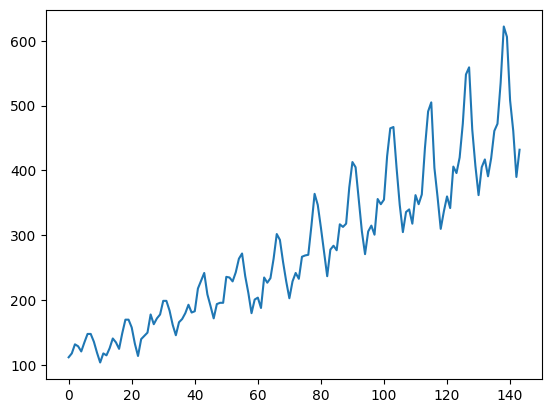

In [2]:
df = pd.read_csv("airline-passengers.csv")
timeseries = df[["Passengers"]].values.astype("float32")

plt.plot(timeseries)
plt.show()

In [3]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_test.shape, y_test.shape)

torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


C:\Users\niki\AppData\Local\Temp\ipykernel_5176\2643546902.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(X), torch.tensor(y)


In [4]:

 class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


C:\Users\niki\AppData\Local\Temp\ipykernel_5176\4122870348.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
C:\Users\niki\AppData\Local\Temp\ipykernel_5176\4122870348.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 225.7894, test RMSE 425.0096
Epoch 100: train RMSE 178.4492, test RMSE 375.3752
Epoch 200: train RMSE 142.4787, test RMSE 336.0862
Epoch 300: train RMSE 112.8606, test RMSE 301.0988
Epoch 400: train RMSE 90.3055, test RMSE 270.3273
Epoch 500: train RMSE 67.7359, test RMSE 235.9655
Epoch 600: train RMSE 52.9218, test RMSE 207.8188
Epoch 700: train RMSE 42.6205, test RMSE 183.7858
Epoch 800: train RMSE 35.5048, test RMSE 162.9637
Epoch 900: train RMSE 30.3665, test RMSE 144.8727
Epoch 1000: train RMSE 27.2744, test RMSE 130.0874
Epoch 1100: train RMSE 24.9865, test RMSE 117.3541
Epoch 1200: train RMSE 23.5112, test RMSE 107.5283
Epoch 1300: train RMSE 22.5042, test RMSE 99.9700
Epoch 1400: train RMSE 21.6369, test RMSE 94.6426
Epoch 1500: train RMSE 21.0504, test RMSE 89.7154
Epoch 1600: train RMSE 21.1131, test RMSE 85.2402
Epoch 1700: train RMSE 20.1550, test RMSE 83.0447
Epoch 1800: train RMSE 20.2966, test RMSE 80.7312
Epoch 1900: train RMSE 19.6977, test RMSE 78.

C:\Users\niki\AppData\Local\Temp\ipykernel_5176\2540086523.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot[lookback:train_size] = y_pred # model(X_train)[:, -1, :]
C:\Users\niki\AppData\Local\Temp\ipykernel_5176\2540086523.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


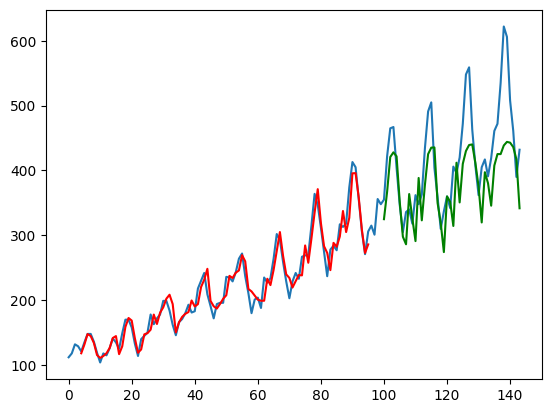

In [5]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = y_pred # model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()